# GLM: Linear regression
このチュートリアルは、Thomas Wiecki によるブログ投稿「The Inference Button: Bayesian GLMs made easy with PyMC」を基にしています。

頻度主義的手法に対するベイジアンの理論的利点については他の場所で詳しく議論されていますが (以下の「参考資料」を参照)、より広範な採用を妨げる主な障害は使いやすさです。 ベイズ統計の美しさは一般性であるため、これは少し皮肉です。 頻度主義統計では、対象のアプリケーションに固有の検定統計を考え出す必要がありますが、ベイズの場合は、適切だと思われるとおりにモデルを正確に定義し、推論ボタン (TM) を押します (つまり、魔法の MCMC サンプリング アルゴリズムを実行します)。

過去数十年にわたり、JAGS、BUGS、Stan などの優れたベイジアン ソフトウェア パッケージがいくつか作成されてきましたが、それらは構築したいモデルをよく知っている統計学者向けに書かれています。

残念ながら、「統計分析の大部分は統計学者によって実行されていない」ため、私たちが本当に必要としているのは統計学者のためのツールではなく、科学者のためのツールです。 PyMC を使用すると、さまざまなフィッティング アルゴリズムの実装方法に関係なく、現在のアプリケーションの統計モデルを簡単に構築できます。

## Linear Regression
この例では、最も単純な GLM (線形回帰) から始めます。 一般に、頻度主義者は線形回帰について次のように考えます。

$$
Y = X \beta + \epsilon
$$

ここで、$Y$ は予測したい出力 (または従属変数)、$X$ は予測子 (または独立変数)、$\beta$ は推定したいモデルの係数 (またはパラメーター) です。 $\epsilon$ は正規分布すると仮定される誤差項です。

次に、通常の最小二乗法 (OLS) または最尤法を使用して、最適な $\beta$ を見つけます。

## Probabilistic Reformulation
ベイジアンは世界を確率論的に捉え、このモデルを確率分布の観点から表現します。 上記の線形回帰は次のように再定式化できます。

$$
Y \sim \mathcal{N} \bigl( X \beta , \sigma ^2 \bigr)
$$

言い換えると、$Y$ を、各要素 (データ ポイント) が正規分布に従って分布する確率変数 (またはランダム ベクトル) として見ます。 この正規分布の平均は、分散 $\sigma ^2$ を持つ線形予測子によって提供されます。

これは本質的に同じモデルですが、ベイズ推定には 2 つの重要な利点があります。

* 事前分布: パラメータに事前分布を設定することで、私たちが持つ可能性のある事前知識を定量化できます。 たとえば、$\sigma$ が小さい可能性が高いと考えられる場合、低い値に対してより多くの確率質量を持つ事前分布を選択します。
* 不確実性の定量化: 上記のように $\beta$ の単一の推定値を取得するのではなく、$\beta$ の異なる値がどの程度存在する可能性があるかについての完全な事後分布を取得します。 たとえば、データ ポイントが少ない場合、$\beta$ の不確実性は非常に高くなり、非常に広い事後分布が得られます。

## Bayesian GLMs in PyMC
PyMC で GLM の構築を開始するには、まず必要なモジュールをインポートしましょう。

In [12]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from pymc import HalfCauchy, Model, Normal, sample

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.12.0


In [13]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

### Generating data
基本的に、切片と傾きで定義される回帰直線を作成し、平均を回帰直線に設定して正規値からサンプリングすることでデータ ポイントを追加します。

In [14]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale = 0.5, size = size)

data = pd.DataFrame(dict(x=x, y=y))

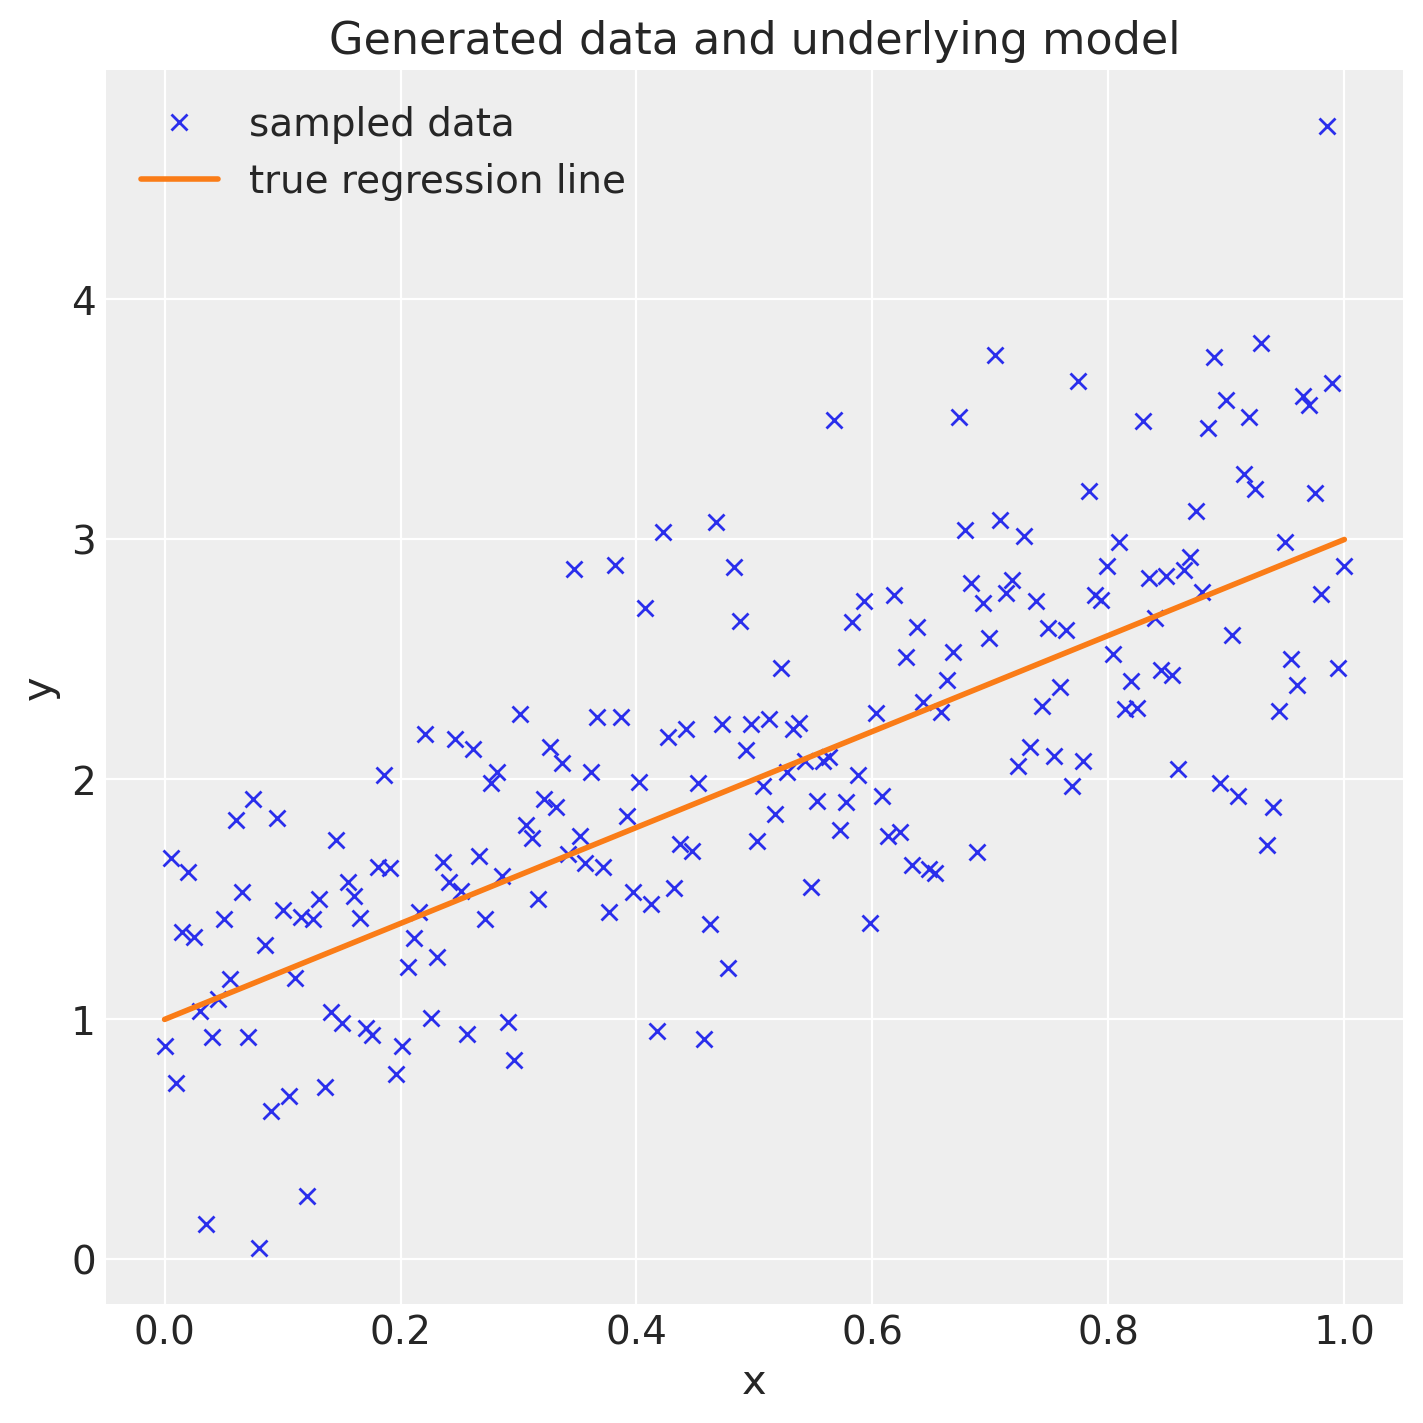

In [15]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel = "x", ylabel = "y", title = "Generated data and underlying model")
ax.plot(x, y, "x", label = "sampled data")
ax.plot(x, true_regression_line, label = "true regression line", lw = 2.0)
plt.legend(loc = 0);

### Estimating the model
このデータにベイジアン線形回帰モデルを当てはめてみましょう。 PyMC では、モデルの仕様はコンテキスト マネージャーと呼ばれる ```with``` 式で行われます。 デフォルトでは、モデルは NUTS サンプラーを使用してフィッティングされ、潜在モデル パラメーターの周辺事後分布を表すサンプルのトレースが得られます。

In [16]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy("sigma", beta = 10)
    intercept = Normal("Intercept", 0, sigma = 20)
    slope = Normal("slope", 0, sigma = 20)

    # Define likelihood
    likelihood = Normal("y", mu = intercept + slope * x, sigma = sigma, observed = y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 27 seconds.


これは、確率的プログラミングを知っている人にとってはかなり読みやすいはずです。 しかし、統計の専門家ではない人に、これが何を意味するのかわかるでしょうか? さらに、これは R では 1 行になる非常に単純なモデルであることを思い出してください。変換される可能性のある複数のリグレッサー、相互作用項、またはリンク関数があると、これがさらに複雑になり、エラーが発生しやすくなります。

物事をさらに単純にするために、```bambi``` ライブラリは数式線形モデル指定子を受け取り、そこから設計行列を作成します。 次に、```bambi``` は各係数の確率変数と適切な尤度をモデルに追加します。

```bambi``` がインストールされていない場合は、 ```pip install bambi``` でインストールできます。

In [17]:
import sys

try:
    import bambi as bmb
except ImportError:
    !{sys.executable} -m pip install -q --upgrade bambi
    import bambi as bmb

In [18]:
model = bmb.Model("y ~ x", data)
idata = model.fit(draws = 3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 26 seconds.


はるかに短いですが、このコードは以前の仕様とまったく同じことを行います (必要に応じて事前分布やその他すべてを変更することもできます)。 ```bambi``` は ```formulae``` モデル文字列を解析し、各回帰変数 (この場合は ```Intercept``` と傾き ```x```) の確率変数を追加し、尤度を追加します。 (デフォルトでは、Normal が選択されます)、および他のすべての変数 (```sigma```)。 最後に、```bambi``` は statsmodels を使用して頻度主義線形モデルを推定することにより、パラメータを適切な開始点に初期化します。

R の構文に詳しくない場合は、```'y ~ x'``` は、```x``` の線形関数として推定する出力変数 ```y``` があることを指定します。

### Analyzing the model
ベイズ推論では、(最尤法のように) 最適な 1 つの行だけが得られるのではなく、もっともらしいパラメーターの事後分布全体が得られます。 パラメーターと抽出した個々のサンプルの事後分布をプロットしてみましょう。

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>],
       [<Axes: title={'center': 'y_sigma'}>,
        <Axes: title={'center': 'y_sigma'}>]], dtype=object)

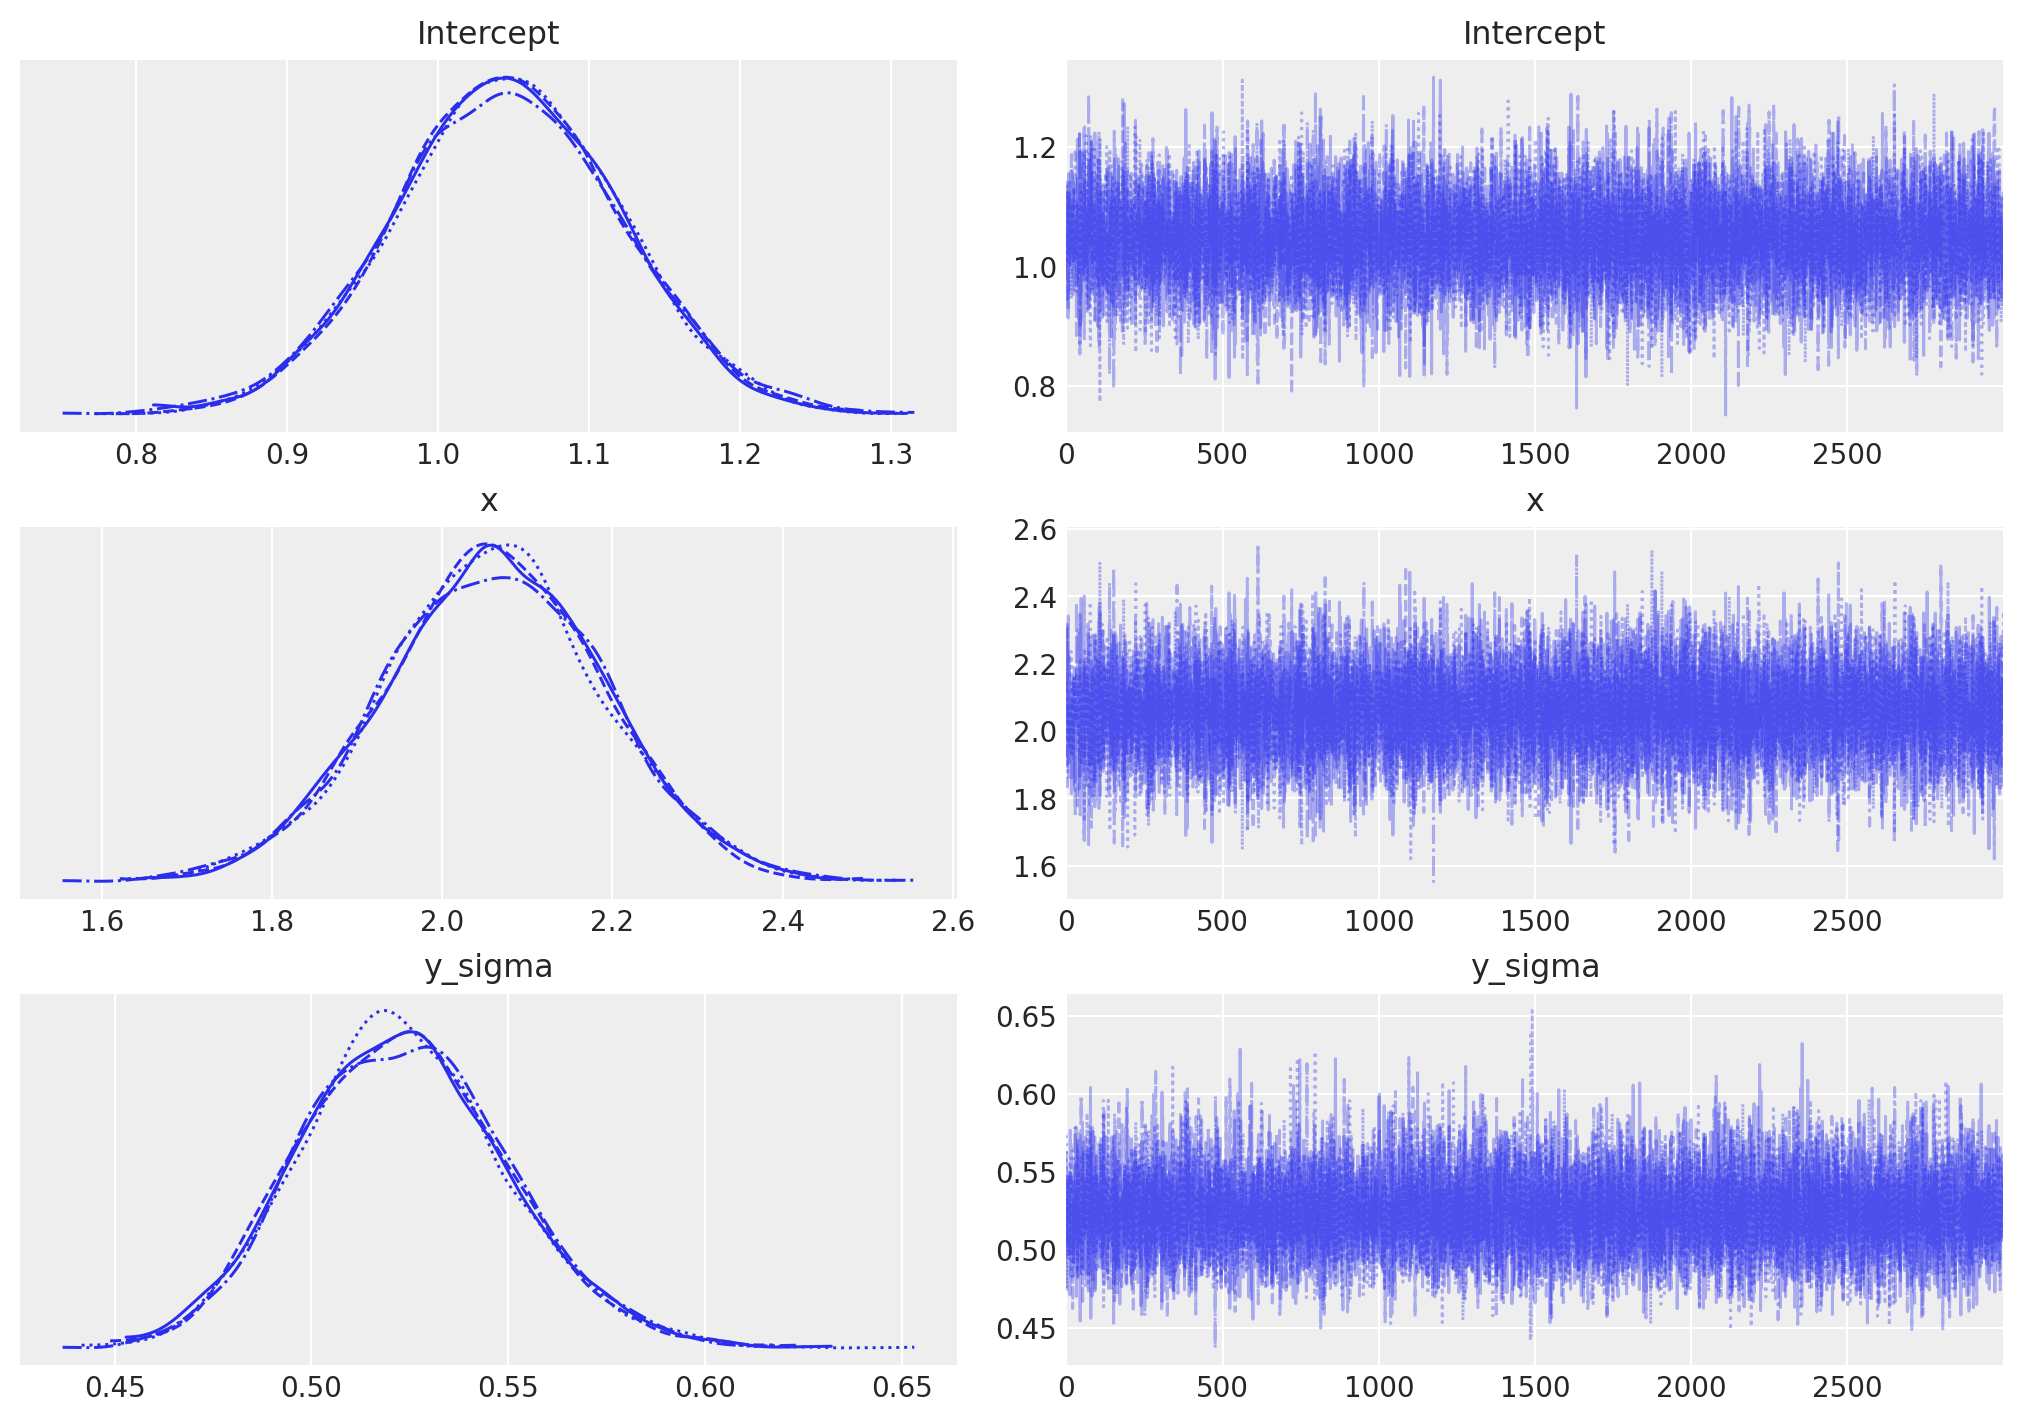

In [19]:
az.plot_trace(idata, figsize=(10, 7))

左側は辺縁後方?を示しています。 X 軸上の各パラメーター値について、そのパラメーター値がどの程度の可能性を示すかを示す Y 軸上の確率が得られます。

ここで見るべきことがいくつかあります。 1 つ目は、個々のパラメーター (左側) のサンプリング チェーンが均一で定常的に見えることです (大きなドリフトやその他の奇妙なパターンはありません)。

第二に、各変数の最大事後推定値 (左側の分布のピーク) は、データの生成に使用された真のパラメーターに非常に近いです (```x``` は回帰係数、```s``` は回帰係数です)。 は正常値の標準偏差です。

したがって、GLM では、最も適合する回帰直線が 1 つだけではなく、多数存在します。 事後予測プロットは、事後から複数のサンプル (切片と傾き) を取得し、それぞれの回帰直線をプロットします。 事後サンプルを直接使用して、これらの回帰直線を手動で生成できます。

In [20]:
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["x"] * xr.DataArray(x)

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\arviz\plots\lmplot.py:211: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)


Text(0.5, 0, 'x')

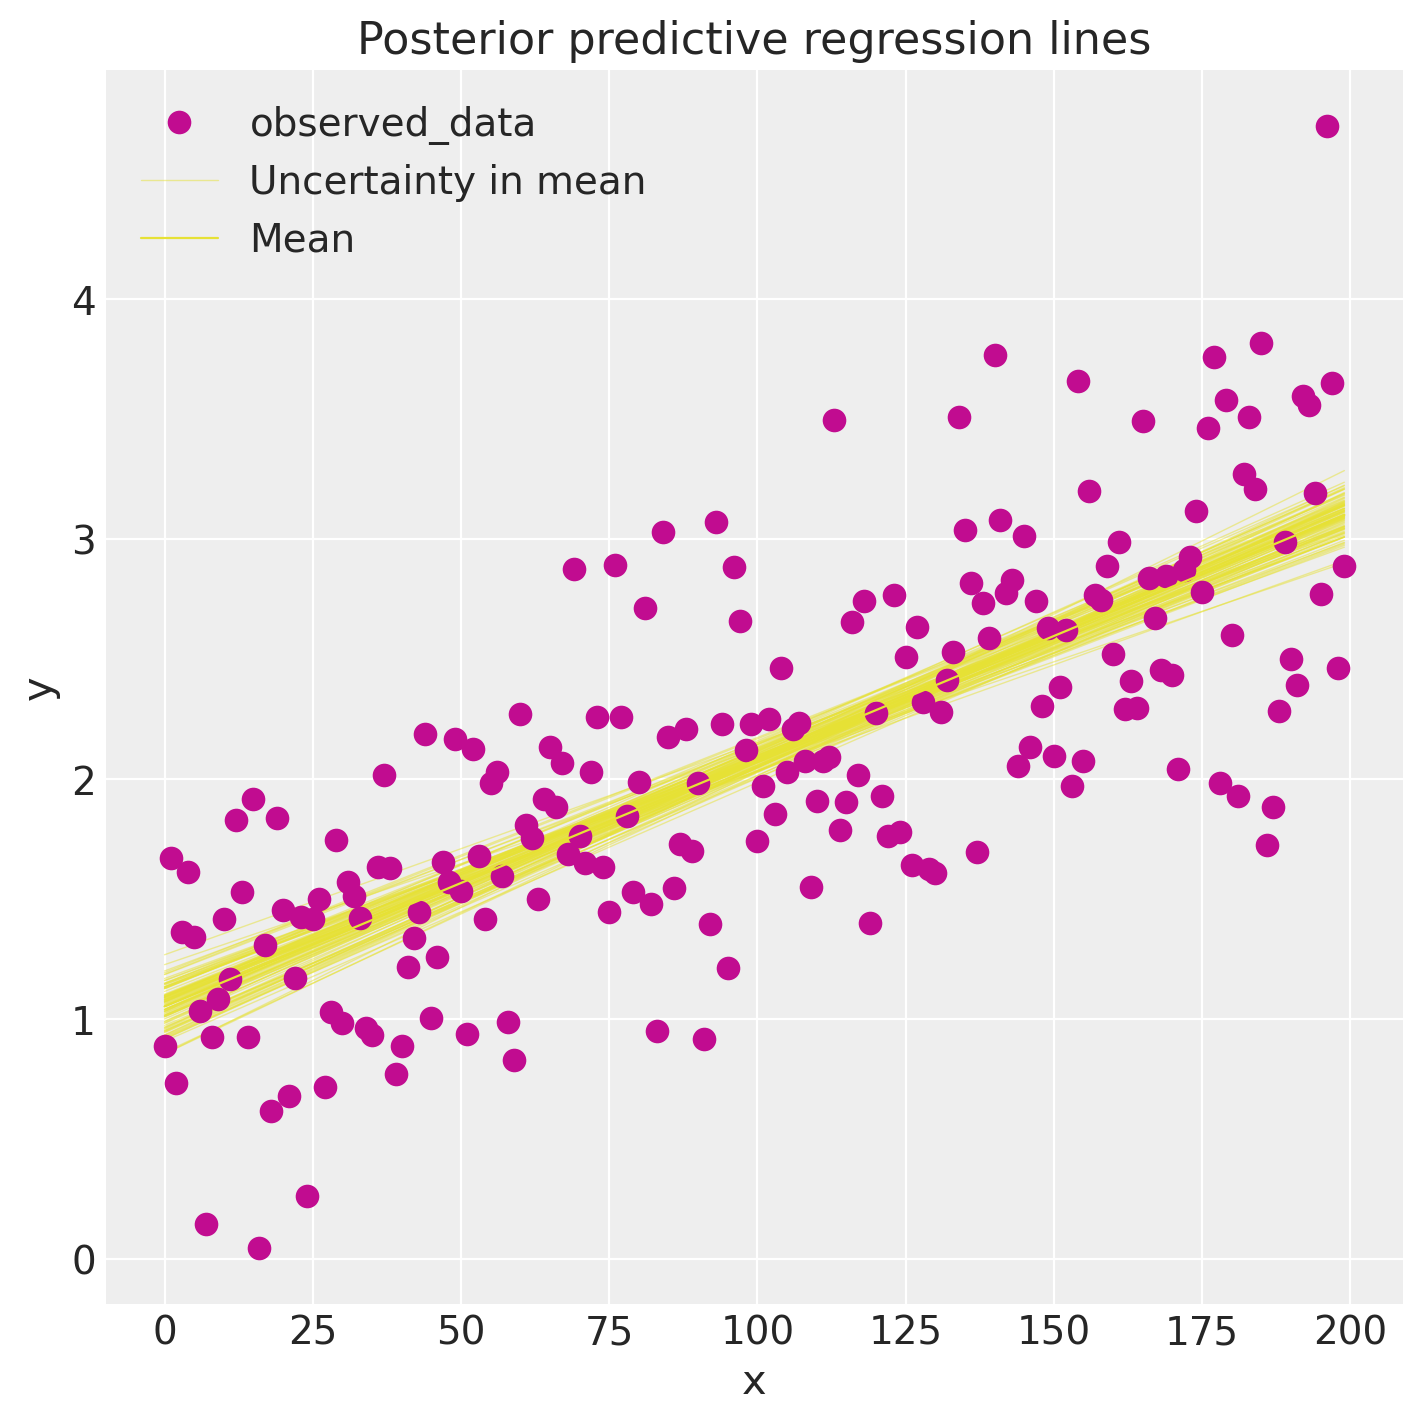

In [21]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata = idata, y = "y", num_samples = 100, axes = ax, y_model = "y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x")

ご覧のとおり、推定された回帰直線は真の回帰直線と非常によく似ています。 しかし、限られたデータしか持っていないため、推定値には不確実性があり、ここでは線のばらつきで表されています。

## Summary
* 現在、ベイズ統計を広く採用するには使いやすさが大きなハードルとなっています。
* ```Bambi``` を使用すると、R から借用した便利な構文を使用した GLM 仕様が可能になります。その後、```pymc``` を使用して推論を実行できます。
* 事後予測プロットにより、適合性とその不確実性を評価できます。

### Further reading
追加の背景については、ベイズ統計に関する優れたリソースをいくつか紹介します。

* John Kruschke による優れた書籍『Doing Bayesian Data Analysis』。
* アンドリュー・ゲルマンのブログ

著者: トーマス・ヴィッキ

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Tue Apr 02 2024

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

pytensor: 2.19.0

matplotlib: 3.8.3
bambi     : 0.13.0
xarray    : 2024.3.0
pandas    : 2.2.1
pymc      : 5.12.0
sys       : 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:40:50) [MSC v.1937 64 bit (AMD64)]
numpy     : 1.26.4
arviz     : 0.17.1

Watermark: 2.4.3

